<div style="overflow:auto;">
    <div style="float:left; margin-right:10px;">
        <img width='120' height='120' src='https://cityme.novaims.unl.pt/images/footer/novaims.png'>
    </div>

# <p align="center">Siemens Sales Forecast</p>

---

## <p align="center">*1 - Exploratory Data Analysis & Pre-processing*</p>

---

### 👥 **Team Members**
- **Ana Farinha** *(Student Number: 20211514)*  
- **António Oliveira** *(Student Number: 20211595)*  
- **Mariana Neto** *(Student Number: 20211527)*  
- **Salvador Domingues** *(Student Number: 20240597)*  

📅 **Date:** *April 1, 2025*  
📍 **Prepared for:** *Siemens*  

**GitHub Repo:** https://github.com/MGN19/Siemens-forecast

---

# ToC

<a class="anchor" id="top"></a>


1. [Import Libraries & Data](#1.-Import-Libraries-&-Data) <br>

2. [Data Wrangling](#2.-Data-Wrangling) <br>

    2.1 [Sales Data](#2.1-Sales-Data) <br>
    
    2.2 [Market Data](#2.2-Market-Data) <br>

3. [Data Exploration](#3.-Data-Exploration) <br>

4. [Feature Exploration](#4.-Feature-Exploration) <br>

5. [Data Cleaning & Preprocessing](#5.-Data-Cleaning-&-Preprocessing) <br>

    5.1 [Duplicates](#5.1-Duplicates) <br>

    5.2 [Extra Data](#5.2-Extra-Data) <br>

    5.3 [Train-Validation Split](#5.3-Train-Validation-Split) <br>
    
    5.4 [Missing Values](#5.4-Missing-Values) <br>
    
    5.5 [Statistical Tests](#5.5-Statistical-Tests) <br>
    
    5.6 [Feature Engineering](#5.6-Feature-Engineering) <br>
    
    5.7 [Outliers](#5.7-Outliers) <br>
    
6. [Final Datasets](#6-Final-Datasets) <br>

# 1. Import Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

#from ydata_profiling import ProfileReport

import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import os

# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

# External Files
import functions as f
import utils as u
import statistical_tests as st
import fs_modelling as fs


pd.set_option('display.max_columns', None)

**Data**

In [2]:
test = pd.read_csv('data/Case2_Test Set Template.csv', 
                 sep = ';')

sales_data = pd.read_csv('./data/Case2_Sales data.csv', 
                 sep = ';')

market_data = pd.read_excel('./data/Case2_Market data.xlsx', 
                            index_col = 'Unnamed: 0')


# 2. Data Wrangling

<a href="#top">Top &#129033;</a>

In this section, we will modify the datasets as needed to improve the results of the forecasting.

## 2.1 Sales Data


In [3]:
sales_data.head(2)

,DATE,Mapped_GCK,Sales_EUR
0,01.10.2018,#1,0
1,02.10.2018,#1,0


**Exploring the dataset structure with .info() method**

The `.info()` method provides more information about the dataset, including the existence of missing values and the data type of the elements of each row.

In [4]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        9802 non-null   object
 1   Mapped_GCK  9802 non-null   object
 2   Sales_EUR   9802 non-null   object
dtypes: object(3)
memory usage: 229.9+ KB


With the information above, we can see the following:
- all of the columns in this dataset are categorical variables. For analysis purposes, the `DATE` column will be transformed into a date format, and the `Sales_EUR` column into a float. 
- we can also see that there might not be any missing values in any of the columns of the dataset.

Based on this, we will first change the data types of these 2 columns identified so that analysis can be proprerly made.

In [5]:
# convert to datetime
sales_data['DATE'] = pd.to_datetime(sales_data['DATE'], 
                                    format='%d.%m.%Y')

# convert to numbers
sales_data['Sales_EUR'] = sales_data['Sales_EUR'].apply(lambda x: x.replace(',', '.')).astype(float)
pd.options.display.float_format = '{:.2f}'.format

sales_data.head(1)

,DATE,Mapped_GCK,Sales_EUR
0,2018-10-01,#1,0.00


**Convert to Monthly Data**

Since the `test` dataset has monthly data, we will perform **downsampling** and reduce the frequency from daily to monthly sales data.

In [6]:
# convert to montlhy sales
sales_data["Date"] = sales_data["DATE"].dt.to_period("M")
monthly_sales = sales_data.groupby(["Date", 
                                     "Mapped_GCK"]).agg({"Sales_EUR": "sum"}).reset_index()

monthly_sales.head(7)

,Date,Mapped_GCK,Sales_EUR
0,2018-10,#1,36098918.79
1,2018-10,#11,1021303.50
2,2018-10,#12,28686.33
3,2018-10,#13,27666.10
4,2018-10,#14,5770.00
5,2018-10,#16,333196.87
6,2018-10,#20,4563.14


Make each Product categ a column

In [7]:
new_monthly_sales = monthly_sales.pivot(index='Date', 
                                 columns='Mapped_GCK', 
                                 values='Sales_EUR')

**Save index as timestamp**

As the index is as `PeriodIndex` (e.g., "2025-03"). By converting to a `TimestampIndex`, we transform the index into datetime object, like 2025-03-01, making it easier to perform certain operations, for instance to visualize sales per month.

In [8]:
new_monthly_sales.index = new_monthly_sales.index.to_timestamp()

**Reorder Columns**

Sorting the products group ascending.

In [9]:
new_order = ['#1', '#3', '#4', '#5', '#6', '#8', '#9', 
             '#11', '#12', '#13', '#14', '#16', '#20', 
             '#36']

new_monthly_sales = new_monthly_sales[new_order]
new_monthly_sales.head(3)

Mapped_GCK,#1,#3,#4,#5,#6,#8,#9,#11,#12,#13,#14,#16,#20,#36
Date,,,,,,,,,,,,,,
2018-10-01,36098918.79,8089465.96,397760.69,2499061.19,369231.60,586052.74,3219.32,1021303.50,28686.33,27666.10,5770.00,333196.87,4563.14,6474.60
2018-11-01,5140760.00,11863001.51,371322.42,8993944.04,473046.96,526292.77,1875.90,1898844.80,1070.00,68180.00,17130.00,1377694.32,5798.14,21617.61
2018-12-01,37889612.12,8736859.39,430100.96,6947507.31,999472.69,271490.71,0.00,1226122.00,17880.60,15655.18,0.00,4762524.66,918.65,13924.52


<br>

## 2.2 Market Data

<a href="#top">Top &#129033;</a>

In [10]:
market_data.head(3)

,China,China.1,France,France.1,Germany,Germany.1,Italy,Italy.1,Japan,Japan.1,Switzerland,Switzerland.1,United Kingdom,United Kingdom.1,United States,United States.1,Europe,Europe.1,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Producer Prices,Producer Prices.1,Producer Prices.2,Producer Prices.3,Producer Prices.4,Producer Prices.5,production index,production index.1,production index.2,production index.3,production index.4,production index.5,production index.6,production index.7,production index.8,production index.9,production index.10,production index.11,production index.12,production index.13,production index.14,production index.15
Index 2010=100 (if not otherwise noted),Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,Production Index Machinery & Electricals,Shipments Index Machinery & Electricals,World: Price of Base Metals,World: Price of Energy,World: Price of Metals & Minerals,World: Price of Natural gas index,"World: Price of Crude oil, average",World: Price of Copper,United States: EUR in LCU,United States: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment,China: Electrical equipment,United States: Machinery and equipment n.e.c.,World: Machinery and equipment n.e.c.,Switzerland: Machinery and equipment n.e.c.,United Kingdom: Machinery and equipment n.e.c.,Italy: Machinery and equipment n.e.c.,Japan: Machinery and equipment n.e.c.,France: Machinery and equipment n.e.c.,Germany: Machinery and equipment n.e.c.,United States: Electrical equipment,World: Electrical equipment,Switzerland: Electrical equipment,United Kingdom: Electrical equipment,Italy: Electrical equipment,Japan: Electrical equipment,France: Electrical equipment,Germany: Electrical equipment
date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_PRO840,MAB_ELE_SHP840,MAB_ELE_PRO1100,MAB_ELE_SHP1100,RohiBASEMET1000_org,RohiENERGY1000_org,RohiMETMIN1000_org,RohiNATGAS1000_org,RohCRUDE_PETRO1000_org,RohCOPPER1000_org,WKLWEUR840_org,PRI27840_org,PRI27826_org,PRI27380_org,PRI27250_org,PRI27276_org,PRI27156_org,PRO28840_org,PRO281000_org,PRO28756_org,PRO28826_org,PRO28380_org,PRO28392_org,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
2004m2,16.94,16.94,112.09,83.46,82.62,79.45,124.29,86.56,109.33,110.50,91.22,89.99,111.35,73.60,107.60,79.24,97.12,80.10,54.04,44.12,48.75,87.08,39.64,36.62,1.26,78.97,80.76,93.02,NaN,93.23,NaN,102.49,97.60,97.10,106.19,116.79,110.89,118.27,80.83,117.72,NaN,81.10,120.71,141.51,106.16,102.08,85.91


As this dataset is not well structured and difficult to interpret, we will make changes on its structure, in terms of columns names. We can see that there are for each different country its production and shipment index for Machinery and Eletricals, producer prices, production index for machinery and equipment and for electrical equipment. It also has prices for natural resources and the conversion of euros to local current units of the country.

In [11]:
info = market_data.T.iloc[:, :2]
info

,Index 2010=100 (if not otherwise noted),date
China,Production Index Machinery & Electricals,MAB_ELE_PRO156
China.1,Shipments Index Machinery & Electricals,MAB_ELE_SHP156
France,Production Index Machinery & Electricals,MAB_ELE_PRO250
France.1,Shipments Index Machinery & Electricals,MAB_ELE_SHP250
Germany,Production Index Machinery & Electricals,MAB_ELE_PRO276
Germany.1,Shipments Index Machinery & Electricals,MAB_ELE_SHP276
Italy,Production Index Machinery & Electricals,MAB_ELE_PRO380
Italy.1,Shipments Index Machinery & Electricals,MAB_ELE_SHP380
Japan,Production Index Machinery & Electricals,MAB_ELE_PRO392
Japan.1,Shipments Index Machinery & Electricals,MAB_ELE_SHP392


**Rename Cols**

In [12]:
market_data = market_data.rename(columns = u.rename_dict)

**Remove unnecessary rows**

In [13]:
market_data = market_data.reset_index()
market_data = market_data[2:]
market_data.rename(columns={'index': 'Date'}, inplace=True)
market_data

,Date,CHI Production Index,CHI Shipments Index,FRA Production Index,FRA Shipments Index,GER Production Index,GER Shipments Index,ITA Production Index,ITA Shipments Index,JAP Production Index,JAP Shipments Index,SWI Production Index,SWI Shipments Index,UK Production Index,UK Shipments Index,USA Production Index,USA Shipments Index,Europe Production Index,Europe Shipments Index,(W) Price of Base Metals,(W) Price of Energy,(W) Price of Metals & Minerals,(W) Price of Natural gas index,"(W) Price of Crude oil, average",(W) Price of Copper,USA EUR to LCU Conversion Rate,USA EE Producer Prices,UK EE Producer Prices,ITA EE Producer Prices,FRA EE Producer Prices,GER EE Producer Prices,CHI EE Producer Prices,USA Machinery & Equipment Index,(W) Machinery & Equipment Index,SWI Machinery & Equipment Index,UK Machinery & Equipment Index,ITA Machinery & Equipment Index,JAP Machinery & Equipment Index,FRA Machinery & Equipment Index,GER Machinery & Equipment Index,USA EE Production Index,(W) EE Production Index,SWI EE Production Index,UK EE Production Index,ITA EE Production Index,JAP EE Production Index,FRA EE Production Index,GER EE Production Index
2,2004m2,16.94,16.94,112.09,83.46,82.62,79.45,124.29,86.56,109.33,110.50,91.22,89.99,111.35,73.60,107.60,79.24,97.12,80.10,54.04,44.12,48.75,87.08,39.64,36.62,1.26,78.97,80.76,93.02,NaN,93.23,NaN,102.49,97.60,97.10,106.19,116.79,110.89,118.27,80.83,117.72,NaN,81.10,120.71,141.51,106.16,102.08,85.91
3,2004m3,23.71,23.71,136.33,106.17,100.56,97.01,143.41,106.34,140.88,144.69,85.87,79.88,127.56,84.05,110.19,98.62,113.78,96.02,54.67,47.59,49.26,87.19,42.59,39.93,1.23,79.67,80.96,93.54,NaN,93.34,NaN,105.63,113.22,91.20,121.63,139.29,141.18,148.12,102.13,119.22,NaN,76.69,138.31,152.88,140.29,117.23,97.67
4,2004m4,24.44,24.44,117.79,92.01,89.65,84.93,129.08,95.58,105.85,102.66,85.62,79.74,108.73,73.03,108.17,89.77,101.72,85.17,54.87,47.78,49.42,91.38,42.65,39.13,1.20,80.34,80.76,93.85,NaN,93.44,NaN,103.48,100.17,93.79,104.97,125.29,105.65,125.48,90.96,117.44,NaN,71.55,115.56,137.80,106.27,105.34,87.25
5,2004m5,23.71,23.71,109.00,85.70,86.88,82.37,135.59,100.09,101.86,100.31,85.38,79.60,110.65,74.59,108.43,87.46,101.28,84.49,51.23,53.59,46.47,99.04,47.52,36.28,1.20,80.80,80.76,93.85,NaN,93.55,NaN,103.64,99.58,96.39,105.89,131.99,101.99,116.65,88.08,117.90,NaN,66.41,119.27,143.86,101.61,96.62,84.68
6,2004m6,27.01,27.01,133.79,106.64,99.01,95.11,136.42,110.89,120.33,119.62,85.13,79.46,122.02,82.34,110.57,97.36,112.06,96.96,52.88,50.80,47.80,98.64,44.97,35.66,1.21,80.91,80.55,93.96,NaN,93.44,NaN,106.06,109.28,98.99,118.25,132.99,122.14,143.25,100.98,119.50,NaN,61.28,128.85,144.32,116.66,118.46,95.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,2021m12,310.76,310.76,100.57,134.59,118.10,149.36,94.01,150.48,127.77,131.03,106.70,104.82,101.27,NaN,107.04,148.59,123.08,150.05,125.21,112.37,116.72,236.49,92.19,126.76,1.13,128.51,NaN,113.31,108.18,115.75,98.11,105.74,134.60,102.28,90.35,103.19,136.98,112.79,129.19,109.62,132.28,114.33,121.07,72.92,109.01,80.76,97.77
217,2022m1,235.96,235.96,85.74,108.16,94.55,120.35,86.85,101.26,110.46,110.82,103.50,101.70,95.00,NaN,111.05,129.57,103.20,120.34,133.22,121.31,125.23,196.91,106.17,129.83,1.13,131.63,NaN,115.39,111.04,117.85,98.28,110.89,117.49,100.31,85.44,92.29,117.86,90.56,92.34,111.36,122.24,109.00,112.32,74.36,95.37,77.94,98.60
218,2022m2,235.96,235.96,90.60,117.72,103.99,129.38,106.58,120.96,117.88,118.30,100.29,98.58,98.46,NaN,116.34,138.56,113.50,131.50,138.91,131.27,131.18,197.52,118.35,131.96,1.13,133.34,NaN,116.43,112.06,118.91,98.71,117.17,124.63,98.33,89.02,113.29,124.71,97.77,102.82,114.69,127.37,103.67,115.56,91.18,103.95,79.00,106.13
219,2022m3,329.41,329.41,107.84,136.86,121.31,151.20,124.64,153.65,152.00,156.40,97.09,95.47,121.99,NaN,117.65,165.93,133.13,158.06,149.89,163.19,141.28,271.08,142.20,1

**Convert dates to datetime**

In [14]:
# convert to datetime
market_data["Year"] = market_data["Date"].str.extract(r"(\d{4})").astype(int)
market_data["Month"] = market_data["Date"].str.extract(r"m(\d{1,2})").astype(int)

market_data["Date"] = pd.to_datetime(market_data["Year"].astype(str) + "-" + market_data["Month"].astype(str), format="%Y-%m").dt.to_period("M")

market_data.drop(['Year', 'Month'], axis = 1, inplace = True)

**Convert numbers to float**

In [15]:
for column in market_data.columns:
    if column in ['Date', 'Month', 'Year']:
        continue
    else:
        market_data[column] = market_data[column].astype(str).str.replace(',', '.', regex=False)
        market_data[column] = pd.to_numeric(market_data[column], errors='coerce')

In [16]:
market_data.set_index('Date', inplace=True)

**Save index as timestamp**

In [17]:
market_data.index = market_data.index.to_timestamp()

In [18]:
market_data.head(4)

,CHI Production Index,CHI Shipments Index,FRA Production Index,FRA Shipments Index,GER Production Index,GER Shipments Index,ITA Production Index,ITA Shipments Index,JAP Production Index,JAP Shipments Index,SWI Production Index,SWI Shipments Index,UK Production Index,UK Shipments Index,USA Production Index,USA Shipments Index,Europe Production Index,Europe Shipments Index,(W) Price of Base Metals,(W) Price of Energy,(W) Price of Metals & Minerals,(W) Price of Natural gas index,"(W) Price of Crude oil, average",(W) Price of Copper,USA EUR to LCU Conversion Rate,USA EE Producer Prices,UK EE Producer Prices,ITA EE Producer Prices,FRA EE Producer Prices,GER EE Producer Prices,CHI EE Producer Prices,USA Machinery & Equipment Index,(W) Machinery & Equipment Index,SWI Machinery & Equipment Index,UK Machinery & Equipment Index,ITA Machinery & Equipment Index,JAP Machinery & Equipment Index,FRA Machinery & Equipment Index,GER Machinery & Equipment Index,USA EE Production Index,(W) EE Production Index,SWI EE Production Index,UK EE Production Index,ITA EE Production Index,JAP EE Production Index,FRA EE Production Index,GER EE Production Index
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-02-01,16.94,16.94,112.09,83.46,82.62,79.45,124.29,86.56,109.33,110.50,91.22,89.99,111.35,73.60,107.60,79.24,97.12,80.10,54.04,44.12,48.75,87.08,39.64,36.62,1.26,78.97,80.76,93.02,NaN,93.23,NaN,102.49,97.60,97.10,106.19,116.79,110.89,118.27,80.83,117.72,NaN,81.10,120.71,141.51,106.16,102.08,85.91
2004-03-01,23.71,23.71,136.33,106.17,100.56,97.01,143.41,106.34,140.88,144.69,85.87,79.88,127.56,84.05,110.19,98.62,113.78,96.02,54.67,47.59,49.26,87.19,42.59,39.93,1.23,79.67,80.96,93.54,NaN,93.34,NaN,105.63,113.22,91.20,121.63,139.29,141.18,148.12,102.13,119.22,NaN,76.69,138.31,152.88,140.29,117.23,97.67
2004-04-01,24.44,24.44,117.79,92.01,89.65,84.93,129.08,95.58,105.85,102.66,85.62,79.74,108.73,73.03,108.17,89.77,101.72,85.17,54.87,47.78,49.42,91.38,42.65,39.13,1.20,80.34,80.76,93.85,NaN,93.44,NaN,103.48,100.17,93.79,104.97,125.29,105.65,125.48,90.96,117.44,NaN,71.55,115.56,137.80,106.27,105.34,87.25
2004-05-01,23.71,23.71,109.00,85.70,86.88,82.37,135.59,100.09,101.86,100.31,85.38,79.60,110.65,74.59,108.43,87.46,101.28,84.49,51.23,53.59,46.47,99.04,47.52,36.28,1.20,80.80,80.76,93.85,NaN,93.55,NaN,103.64,99.58,96.39,105.89,131.99,101.99,116.65,88.08,117.90,NaN,66.41,119.27,143.86,101.61,96.62,84.68


<br>

# 3. Data Exploration

<a href="#top">Top &#129033;</a>

## 3.1 Sales data

In [ ]:
# profile = ProfileReport(
#     new_monthly_sales, 
#     title='Data',
#     correlations={
#         "pearson": {"calculate": True},
#         "spearman": {"calculate": False},
#         "kendall": {"calculate": False},
#         "phi_k": {"calculate": False},
#         "cramers": {"calculate": False},
#     },
# )

# profile

- #11 is highly overall correlated with #8	
- #12 is highly overall correlated with #3 and 1 other fields	
- #3 is highly overall correlated with #12 and 1 other fields	
- #5 is highly overall correlated with #3	
- #8 is highly overall correlated with #11 and 2 other fields

<br>

**Statistics**

By using the `describe()` method we get different statistical measurements, such as mean and standard deviation, for the various features.

In [ ]:
new_monthly_sales.describe().T

From a first overview, we can see the following:

- No missing entries, as all columns have 43 observations
- Product category #6, #9, #14 have negative sales, this might be due to returns of the products
- There is one month where product category #20 was not sold
- Product category #1, seems to have the highest sales performance among other product categories. This based on minimum, maximum and quartile values. Followed by product category #3
- Product category #20 has lowest sales.

<br>

## 3.2 Market Data

In [ ]:
# profile2 = ProfileReport(
#     market_data, 
#     title='Data',
#     correlations={
#         "pearson": {"calculate": True},
#         "spearman": {"calculate": False},
#         "kendall": {"calculate": False},
#         "phi_k": {"calculate": False},
#         "cramers": {"calculate": False},
#     },
# )

# profile2

<br>

**Exploring the dataset structure with .info() method**

In [ ]:
market_data.info()

With the information above, we can see there are missing values in:

- SWI Production Index  
- SWI Shipments Index  
- UK Shipments Index  
- USA Shipments Index  
- UK EE Producer Prices  
- FRA EE Producer Prices  
- CHI EE Producer Prices  
- SWI Machinery & Equipment Index  
- (W) EE Production Index  
- SWI EE Production Index  


**Statistics**

In [ ]:
market_data.describe()

Based on this, we get the following:

1. **Production and Shipments in Machinery & Electricals**  
   - China’s production and shipment index show high variability, indicating for instance fluctuations in demand, supply chain issues, or policy impacts. At some point in time, Production and Shipments was over 3 times higher than in 2010 (229% increase) 
   - Based on the minimum values, we can see that all countries, at some point, there was a decline in production and shipment, as indicated by the values well below 100. This could be due to economic crises or supply chain disruptions (such as semiconductors shortages), etc.
   - Switzerland has the lowest production and shipment index, compared to the other countries, based on values of minimum and quartiles.
   - UK tends to produce more than export
   - Germany’s shipment index mean (114.9) is higher than its production mean (107.5), which could indicate a focus on exports and strong international demand. Europe also has a higher index in terms of shipment than production and USA too.

3. **Resources Prices** 
   - Natural gas prices (mean: 103.37, std: 103.37) show high volatility, likely driven by geopolitical factors and global supply-demand shocks. 25% or less of the observations had values lower than in 2010. 
   - Coper and metals and minerals price seem to be the cheapest resources.

4. **Producer Prices**  
   - Germany has the highest producer price mean (103.17), closely followed by USA (102.19) and Italy (102.16). This suggests that companies in these countries are paying more to produce goods. 
   - China’s mean producer price is lower than others (97.68), being the cheapest country to produce.

5. **Machinery & Equipment Production**  
   - Japan has the highest production mean (115.08), followed by Germany (110.90) and the U.S. (110.42), indicating a strong machinery sector production.
   - Switzerland has the lowest production indexes (on average 99.7).
   - At some point in time, we can see based on the minimum values that production, in all countries, was lower compared to 2010.

6. **Electrical Equipment Production**
   - UK has the highest average production compared to other companies, indicating strong electrical equipment production.
   - Switzerland in 50% of the cases has produce less than in 2010 and compared to other countries, produces less.

# 4. Feature Exploration

<a href="#top">Top &#129033;</a>

## 4.1 Univariate Analysis

<a href="#top">Top &#129033;</a>

#### **Sales Data**

Sales Distribution

In [ ]:
f.plot_sales_data(new_monthly_sales)

Percentage change in sales revenue for each product

In [ ]:
f.percentage_change(new_monthly_sales)

In [ ]:
f.percentage_change_previous_month(new_monthly_sales)

##### Notes:

**Product # 1:**

Significant decline on November 2018 (decrease of almost 86%). Due to this, the percentage change comparing 2019 to 2018 is also higher. According to Siemens’ Annual Report 2018, there was a significant decline in the Power and Gas Division, which specializes in gas turbines. This might be due to the global shift towards renewable energy. In the same report, we can find that “ Volume in that segment declined significantly in fiscal 2018 due mainly to customer delays of large projects in the Americas and in the Middle East and strong price pressure resulting from intense competition.” This could suggest that this product category (#1) is part of th division, although it has not been explicitly confirmed. While we cannot treat this as definitive, it will be taken into account for consideration. The sales in this segment generally range from 35 to 42 million monetary units. October of 2021 had larger sales.

Siemens AG. (2018). Annual report 2018. Siemens AG. https://assets.new.siemens.com/siemens/assets/api/uuid:4bfbab10-00d6-4a22-aad2-b50f3f232bfb/siemens-annual-report-2018.pdf


**Product #3:**

Significant decline from October 2020 until January 2021, probably due to Covid-19 pandemic and/or semiconductor shortages. After that there was an increase and the sales stabilize between 10 million and almost 19 million monetary units. This represented the highest sales revenue change in this product category. Most of the sales were between 10 million and 14 million monetary units. 

Note: As the distribution of the sales represents almost a Gaussian distribution, it is important to check whether this represents White noise, or not.

**Product #4:**

Overall lower sales compared to products category #1 and #3. Maximum sales was above 800 000 in February and June and represented the highest change in sales revenue. The sales revenue were between 170 000 and 470 000. There were some notable declines between February and April 2021, as well as from June to August of the same year. Comparing to the same month of the previous year, we can see that there was increase in October 2020 (comparing to 2019) and February 2021 (comparing to 2020).

**Product #5:**

The majority of sales revenue falls between 7 million and 12 million. The product shows fluctuations in sales, with the lowest sales recorded in January 2021, which also happened with product category #3. 

**Product #6:**

After December 2019, there was a significant decline, leading to negative sales in January 2020. This could be attributed to factors like shipments being delayed or impacted, possibly due to the early effects of COVID-19 in China, which might have affected product deliveries. Between August 2020 and January 2021, there was another decrease, although some stabilization occurred between September and December. By September 2021, sales nearly reached 1 million in revenue.

**Product #8:**

We can see that between the end of 2018 and March 2021 there was an increase in sales of this product category, even though some declines occurred. The most noticeable decrease in revenue was in October 2021 (less than 500 000 monetary units). 

**Product #9:**

In December 2019, no sales were registered. We can see a noticeable pick in sales from September to October 2020 (reaching almost 40 000 monetary units), followed by a significant decline in the following month. October 2020 had a higher revenue sales compared to 2019.

**Product #11:**

There are some fluctuations in sales, but we can observe that every September, there is always a significant increase in sales, followed by a notable decline the following month. In January 2021, sales reached almost 0 in revenue. The biggest difference in terms of month was in January 2022 compared to 2021.

**Product #12:**

Between October 2018 and August 2019, the revenue remained below 100 000 monetary units. However, in September 2019, there was a significant increase, reaching nearly 300 000 monetary units. The highest revenue was recorded in October 2020. Afterward, the revenue fluctuated between 100 000 and almost 430 000 monetary units. November 2019 had the biggest change compared to 2018.

**Product #13:**

The major revenue peaks occurred in November 2018, October 2019, and March 2021. The majority of sales revenue typically ranged between 15 000 and 35 000 monetary units.

**Product #14:**

This product category has the highest reported no sales compared to the other products, with some reported negative sales in 2020, probably due to returns and Covid-19. July 2021 had the highest total revenue in sales, almost 80 000. Most of the revenue in sales is below 10 000 monetary units.

**Product #16:**

The highest peak in sales occurred in December 2018, reaching nearly 5 million monetary units. After April 2019, sales declined significantly and then stabilized, with revenue ranging between 20 000 and 270 000 monetary units.

**Product #20:**

There were months with no sales activity. The highest revenue peak occurred in December 2020, followed by another significant rise in April 2021. However, in January 2021, no sales were recorded, and from January to March of the same year, sales revenue remained below 2000 monetary units. Starting in February 2022, sales began to increase.

**Product #36:**

Sales revenue in this product category stayed below 50 000 monetary units, except in June 2020 and April 2021, when the revenue exceeded 250 000 monetary units.

In [ ]:
f.sales_data_line(new_monthly_sales)

<div class="alert-danger">
    
# WHY

Interesting to see that in January 2021, Siemens faced a decrease in sales revenue for all product categories. In some cases, these sales were non-existent, like with product #20.

In [ ]:
f.plot_boxplots(new_monthly_sales)

As expected, over these three and a half years of sales data, there are some values that stand out as extreme points. For example, with Product #1, the significant decline in sales observed in November 2018 is clearly reflected in the boxplot.

<br>

#### **Market Data**

Resources prices

In [ ]:
resources_prices = [
    '(W) Price of Base Metals', '(W) Price of Energy', '(W) Price of Metals & Minerals',
    '(W) Price of Natural gas index', '(W) Price of Crude oil, average', '(W) Price of Copper'
]

f.resource_prices(market_data, resources_prices)

We can see that between 2004 and 2022, there have been fluctuations. Focusing on the period between 2008 and 2022, we observe that:

- Price of base metals: After February 2021, the price of this resource was higher than in 2010. The lowest price was recorded in April 2020.
This might be largely due to the COVID-19 pandemic, reducing demand for industrial metals. However, as economies started to recover this helped to increase prices by 2021.

- Price of energy: After September 2021, the price of this resource was higher than in 2010. The lowest price was recorded in April 2020. Energy prices collapsed in early 2020 due to lockdowns, which led to a significant drop in demand, possibly influenced by policy regulations imposing energy price limits.

- Price of natural gas: After July 2021, the price of this resource was higher than in 2010. The lowest price was recorded in April 2020.

- Price of crude oil: After January 2022, the price of this resource was higher than in 2010. This might be influenced by OPEC+ production cuts, which helps reduce supply and therefore increase prices. The lowest price was recorded in June 2020. 

- Price of copper: After December 2020, the price of this resource was higher than in 2010. The lowest price was recorded in April 2020.

Production and Shipment Index for Machinery & Electricals

In [ ]:
prod_ship_index = market_data.iloc[:, 0:18] 

In [ ]:
f.plot_prod_ship_index(prod_ship_index)

In [ ]:
f.plot_filtered_prod_ship_index(prod_ship_index)

- China had a a tendency of increasing its production and shipments index. After more or less 2013 the production and shipment index was higher than in 2010. Between 2018 and 2022, the lowest production and shipment index occur on January and February of 2020. Interesting to see, that production index and shipment index are always equal in China, this might be due to Just-in-Time manufacturing system where goods are produced only when they are needed and shipped directly;

- Between 2008 and 2010, France had a decline in production and shipment probably due to the effects of the global crisis. In terms of shipment, France tends to ship more than produces. Between 2018 and 2022, most of the time the production was lower than in 2010, contrarily to the shipment index that was always above, except during the pandemic (February to August);

- Overall, Germany during 2004 and 2022 have been producing and shipping more than in 2010, with some exceptions between the global crisis of 2008 and the pandemic in 2020.

- Italy's production and shipment index fluctuates, with some high declines. The highest production and shipment of machinery and eletrics occured between 2004 and 2008. Between 2018 and 2022, Italy shipped more compared to 2010, and produced less compared to 2010. We can also see that due to the pandemic these 2 economic activities were affected.

- The two major declines in Japan's production and shipment occur during 2008 and during the pandemic.

- Switzerland production and shipment index fluctuates, however we can see a pattern that is whenever there is an increase in production, there is also in shipment. Most of the products that are produced are shiped. During January 2020 and August 2021, production and shipment in Switzerland was lower than 2010.

- During 2004 and 2010, UK' production was higher than 2010 and lower in terms of shipment. During the pandemic both productiona and shipment were affected and were lower than 2010.

- The USA production overall was only affected during 2008 and the pandemic. While the shipment only affected on the early years of 2004 and during the crisis of 2008. USA shipment was always greater than in 2010 during 2018 and 2022.

- Europe and the USA exhibited similar patterns in terms of shipment and production.

<br>

## 4.2 Bivariate and Multivariate Analysis

<a href="#top">Top &#129033;</a>

##### **Sales Data**

Percentage of each product per year

In [ ]:
copy = new_monthly_sales.copy().reset_index()
copy["Year"] = copy["Date"].dt.year
copy = copy.drop(columns=["Date"])
yearly_data = copy.groupby("Year").sum()
df_percent = yearly_data.div(yearly_data.sum(axis=1), axis=0) * 100
df_percent = df_percent.applymap(lambda x: f"{x:.2f}%")
df_percent


Sales per product per year

In [ ]:
f.plot_stacked_bar(yearly_data)

Based on the output above, we can see that the highest sales revenue comes from product category #1, followed by #3 and #5. Products #9, #12, #13, #14, #20, and #36 contribute little to sales revenue each year, sometimes showing no sales at all. The sales in 2018 and 2022 appear lower than the sales in other years, as our data only covers 3 and 4 months of those years, respectively. We observed a decrease in sales of approximately 20 millions from 2019 to 2020, which could be attributed to various factors, including the Covid pandemic and the Ukraine war. However, there was a significant increase of almost 36 millions in sales from 2020 to 2021.

Pairwise relationship between products

In [ ]:
corr = np.round(new_monthly_sales.corr(method="pearson"), decimals=2)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            annot=True, 
            mask=mask, 
            cmap='inferno', 
            fmt='.2f', 
            vmin=-1, vmax=1, 
            center=0, 
            square=True, 
            linewidths=0,  
            cbar_kws={'shrink': 0.7, 'label': 'Correlation Coefficient'},
            annot_kws={"size": 10, "color": "white", "ha": "center", "va": "center"},  
            linecolor='white')

plt.title('Correlation Matrix', fontsize=16, color='black', pad=20)
plt.grid(False)
plt.subplots_adjust(top=0.9, bottom=0.08, left=0.08, right=0.92)
plt.show()

In [ ]:
f.plot_high_correlation_pairs(new_monthly_sales)

Based on this we can see that even though the correlation is not too high, the highest positive correlations (above 0.5) are between product category:
- #8 and #12 (0.6)
- #8 and #11
- #3 and #5
- #3 and #12
- #3 and #8

If we check the line plots of the sales of each product category that was seen in the section `4.1 Univariate Analysis`, it is possible to see that normally when the sales revenue of one product category increases, the other tends to increase, and vice versa. This might suggest that these two product categories may be complementary to each other.

Monthly sales per year

In [ ]:
fig = f.monthly_sales_per_year(new_monthly_sales)
fig.show()

**2018**

- Product #1 sales revenue decrease. 
- Slight increase in sales revenue for products #3 and #5

**2019**

- After April, product #1, stabilize in terms of sales around 40 millions
- Increase from July until September of revenues for product #11
- Sales revenue fluctuation for product #5

**2020 and 2021**
- More fluctuations specially for product #1 and #5, probably due to Covid-19 pandemic and semiconductor shortages
- Product #3 revenue sales remained more or less the same compared to 2019.
- All products had a decrease in sales in January 2021

**2022**
- Increase in sales revenue in March 2022 for mostly all products

Monthly sales over time

In [ ]:
f.monthly_sales(new_monthly_sales)

https://online.stat.psu.edu/stat510/lesson/5/5.1

In [ ]:
f.multiplicative_seasonal_decomposition(new_monthly_sales, excluded_columns=['#14', '#20', '#6', '#9'])

In [ ]:
f.additive_seasonal_decomposition(new_monthly_sales, excluded_columns=['#14', '#20', '#6', '#9'])

<br>

##### **Market Data**

Production and Shipment over time by country

In [ ]:
production_columns = [
    'CHI Production Index', 'FRA Production Index', 'GER Production Index', 
    'ITA Production Index', 'JAP Production Index', 'SWI Production Index',
    'UK Production Index', 'USA Production Index', 'Europe Production Index'
]
production_data = market_data[production_columns]
f.plot_production_index(market_data, production_data)

In [ ]:
shipment_columns = [
    'CHI Shipments Index', 'FRA Shipments Index', 'GER Shipments Index', 
    'ITA Shipments Index', 'JAP Shipments Index', 'SWI Shipments Index',
    'UK Shipments Index', 'USA Shipments Index', 'Europe Shipments Index'
]
shipment_data = market_data[shipment_columns]

f.plot_shipment_index(market_data, shipment_data)

Overall, since 2013, China has consistently had higher production indexes compared to other countries. Compared to other countries that have no consistent trend (upward or downward) over the entire time span. Additionally, seasonality is evident, with China's production experiencing the largest decline in January and February, maintaining the same production index during those months. This might be due to the Chinese New Year that results in factories closed. Meanwhile, Italy and France see a decline in production every August, probably due to summer shutdown. Japan's production always increase every March. 

The same applies for the shipment.

Producer prices of electrical equipment over time by country

In [ ]:
producer_prices = ['USA EE Producer Prices', 'UK EE Producer Prices',
                     'ITA EE Producer Prices', 'FRA EE Producer Prices',
                     'GER EE Producer Prices', 'CHI EE Producer Prices',
]
producer_price_data = market_data[producer_prices]

f.plot_producer_price(market_data, producer_price_data)

Until around the end of November 2008, China had the highest producer prices, even surpassing those in 2010. Between 2009 and 2012, prices stabilized and were relatively similar across all countries. However, after 2011, a paradigm shift occurred: China became the lowest-cost producer, while the UK emerged as the leader until October 2020. After that, the USA took the lead with the highest producer prices, followed by Germany.

Machinery and Equipment Index over time by country

In [ ]:
me_index = ['USA Machinery & Equipment Index', '(W) Machinery & Equipment Index',
       'SWI Machinery & Equipment Index', 'UK Machinery & Equipment Index',
       'ITA Machinery & Equipment Index', 'JAP Machinery & Equipment Index',
       'FRA Machinery & Equipment Index', 'GER Machinery & Equipment Index'
]

me_index_data = market_data[me_index]
f.plot_me_index(market_data, me_index_data)

Based on the insights about seasonality earlier, similar patterns can be observed across countries. In Italy and France, there is consistently a decline in machinery and equipment production in August, while Japan experiences an increase in March each year. Additionally, Germany typically sees a decrease in production during January, with a peak in December. Overall, all countries experienced a decline in production between March 2008 and July 2009. During the pandemic, the UK faced the largest reduction in production compared to the others. From 2018 to 2022, Japan consistently maintained higher production levels than the other countries.

In [ ]:
ee_index = ['USA EE Production Index', '(W) EE Production Index',
       'SWI EE Production Index', 'UK EE Production Index',
       'ITA EE Production Index', 'JAP EE Production Index',
       'FRA EE Production Index', 'GER EE Production Index'
]

ee_index_data = market_data[ee_index]
f.plot_ee_index(market_data, ee_index_data)

Similar to the insights above regarding machinery and equipment, the same production seasonality trends apply to electrical equipment. Until 2010, there was a slight decline in production, with Switzerland being the lowest producer and Italy the highest. From 2018 to 2022, the UK consistently had the highest production index compared to other countries, reaching around 46% higher in March 2022 than in 2010.

Production and Shipment Index

In [ ]:
prod_ship_index = market_data.iloc[:, 0:18] 
corr = np.round(prod_ship_index.corr(method="pearson"), decimals=2)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            annot=True, 
            mask=mask, 
            cmap='inferno', 
            fmt='.2f', 
            vmin=-1, vmax=1, 
            center=0, 
            square=True, 
            linewidths=0,  
            cbar_kws={'shrink': 0.7, 'label': 'Correlation Coefficient'},
            annot_kws={"size": 10, "color": "white", "ha": "center", "va": "center"},  
            linecolor='white')

plt.title('Correlation Matrix', fontsize=16, color='black', pad=20)
plt.grid(False)
plt.subplots_adjust(top=0.9, bottom=0.08, left=0.08, right=0.92)
plt.show()

In China, production and shipment indices are perfectly correlated (1.00), indicating that every unit produced is also shipped. Similarly, Japan exhibits an almost identical relationship (0.99), followed by Switzerland (0.97) and Germany (0.90).

Germany appears to have a significant influence on several European economies. Increases in German production are closely linked to rising shipments in the UK (0.79) and Italy (0.66), suggesting that these countries rely on materials or intermediate goods from Germany. Additionally, Germany's production growth strongly influences overall European production (0.83) and shipments (0.84), reinforcing its central role in Europe.

On the shipment side, a rise in Germany’s shipment index correlates strongly with higher shipments across Europe (0.95) and the USA (0.81). This trend is also followed by the UK (0.78), possibly due to global trade networks, particularly in transatlantic supply chains.  

An increase in French production tends to drive growth in Italy (0.85) and the UK (0.76), indicating supply chain dependencies or shared economic cycles among these nations.  

China’s production and shipment growth have broader global implications. An increase in China’s indices is associated with increased shipments to the USA (0.74) and Germany (0.73). However, this growth appears to coincide with a decline in both production and shipments in France, with a negative correlation of 0.50 in both cases. This may suggest that rising Chinese exports create competitive pressures on certain French industries, leading to reduced domestic production and shipping activity. 

Prices Indexes

In [ ]:
corr = np.round(market_data[resources_prices].corr(method="pearson"), decimals=2)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            annot=True, 
            mask=mask, 
            cmap='inferno', 
            fmt='.2f', 
            vmin=-1, vmax=1, 
            center=0, 
            square=True, 
            linewidths=0,  
            cbar_kws={'shrink': 0.7, 'label': 'Correlation Coefficient'},
            annot_kws={"size": 10, "color": "white", "ha": "center", "va": "center"},  
            linecolor='white')

plt.title('Correlation Matrix', fontsize=16, color='black', pad=20)
plt.grid(False)
plt.subplots_adjust(top=0.9, bottom=0.08, left=0.08, right=0.92)
plt.show()

The price of base metals is highly influenced by the price of metals and minerals (0.98) and copper (0.94), indicating that an increase in one typically drives an increase in the others.  

Similarly, energy prices are closely tied to crude oil prices, with a near-perfect correlation (0.99), emphasizing oil's dominant role in the energy market. Additionally, the price of metals and minerals shows a strong correlation with copper prices (0.95), further highlighting copper’s significance in the broader materials sector.  

However, when analysing energy prices in relation to other resources, no major correlations emerge. The strongest observed relationship is with general energy prices (0.58), suggesting that while energy markets are somewhat interconnected, their price movements are less directly influenced by other resource categories.

Producer Prices Electrical Equipment

In [ ]:
corr = np.round(market_data[producer_prices].corr(method="pearson"), decimals=2)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            annot=True, 
            mask=mask, 
            cmap='inferno', 
            fmt='.2f', 
            vmin=-1, vmax=1, 
            center=0, 
            square=True, 
            linewidths=0,  
            cbar_kws={'shrink': 0.7, 'label': 'Correlation Coefficient'},
            annot_kws={"size": 10, "color": "white", "ha": "center", "va": "center"},  
            linecolor='white')
plt.title('Correlation Matrix', fontsize=16, color='black', pad=20)
plt.grid(False)
plt.subplots_adjust(top=0.9, bottom=0.08, left=0.08, right=0.92)
plt.show()

Globally, producer prices are connected because of competition between countries. When prices go up or down in one country, it often affects others.  

Germany’s producer prices are closely linked to those in the USA, UK, and Italy, meaning they tend to rise and fall together. France’s prices move similarly to those in Italy and the USA, while Italy’s prices are connected to both the UK and the USA. The UK and USA also show a strong connection in their price trends.  

However, China is different. Its producer prices have a negative correlation with those of Germany, the USA, the UK, France, and Italy. This means that when prices rise in these countries, China’s prices often remain low or even decrease. Since China has the lowest production costs, as seen before, and it puts pressure on other countries to keep their prices competitive.

Production Index Machinery Equipment

In [ ]:
production_index_me_ee = market_data.iloc[:, 32:49] 
corr = np.round(production_index_me_ee.corr(method="pearson"), decimals=2)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            annot=True, 
            mask=mask, 
            cmap='inferno', 
            fmt='.2f', 
            vmin=-1, vmax=1, 
            center=0, 
            square=True, 
            linewidths=0,  
            cbar_kws={'shrink': 0.7, 'label': 'Correlation Coefficient'},
            annot_kws={"size": 10, "color": "white", "ha": "center", "va": "center"},  
            linecolor='white')

plt.title('Correlation Matrix', fontsize=16, color='black', pad=20)
plt.grid(False)
plt.subplots_adjust(top=0.9, bottom=0.08, left=0.08, right=0.92)
plt.show()

When production in the machinery and equipment sector increases, Italy also experiences growth (0.82), highlighting its strong connection to this industry. On a global scale, Germany (0.76) and Japan (0.70) play a major role in machinery and equipment production. An increase in production in these two countries often leads to a rise in global production levels, showing their influence on the market.  

In France, electrical equipment production tends to grow when there is an increase in machinery and equipment production, as well as when electrical equipment production rises in Italy. This suggests a close link between these sectors across countries.  

Additionally, production in Japan shows a mutual relationship that when one sector sees an increase, the other also tends to grow.

However, there is a negative relationship between Switzerland’s electrical equipment production and that of the USA (-0.40) and Italy (-0.46). This suggests that when electrical equipment production rises in Switzerland, it tends to decline in these two countries.

<br>

### 4.2.1 Germany's market

Since we are analyzing Siemens' sales revenue in Germany, this section will focus specifically on the German market after October 2018.

In [ ]:
ger_columns = market_data.filter(like='GER', axis=1)
ger_columns.head()

In [ ]:
# Filter the rows between 2018 and the end of the dataset
filtered_ger_columns = ger_columns[(ger_columns.index.year >= 2018) & (ger_columns.index.month >= 10)]
filtered_ger_columns.head()

In [ ]:
# check the germany_market DataFrame information
filtered_ger_columns.describe()

In [ ]:
f.resource_prices(filtered_ger_columns, filtered_ger_columns.columns, title = 'Germany Production Index')

Overall, production in Germany had increased and was higher than in 2010. The only exception is the electrical equipment sector, where in 25% or fewer instances, production was lower than in 2010, primarily due to the impact of the pandemic. However, we can see in the EE production that in November of each year, production is higher than in 2010 and in December is lower.

<br>

# 5. Data Cleaning & Preprocessing

<a href="#top">Top &#129033;</a>

## 5.1 Duplicates

##### **Sales Data**

In [ ]:
new_monthly_sales[new_monthly_sales.duplicated()]

##### **Market Data**

In [ ]:
market_data[market_data.duplicated()]

No duplicate values in both data sets.

## 5.2 Extra Data

<a href="#top">Top &#129033;</a>

In [19]:
# Find the start date of the new_monthly_sales dataset
start_date = new_monthly_sales.index.min()

# Filter market_data to match the start date of new_monthly_sales
market_data_filtered = market_data[market_data.index >= start_date]

**Import Extra Data**

In [20]:
stocks = pd.read_csv('./extra data/clean_stock_data.csv', index_col = 'Date')
consumer_conf = pd.read_csv('./extra data/clean_consumer_confidence.csv', index_col = 'TIME_PERIOD')
business_conf = pd.read_csv('./extra data/clean_business_confidence.csv', index_col = 'TIME_PERIOD')
covid = pd.read_csv('./extra data/stringency_index.csv', index_col = 'date')
clean_energy = pd.read_csv('./extra data/clean_energy.csv', index_col = 'Date')
fossil_energy = pd.read_csv('./extra data/fossil_energy.csv', index_col = 'Date')
building_permits = pd.read_csv('./extra data/buildings_data.csv', index_col = 'date')

**Rename Columns**

In [21]:
stocks = stocks.rename(columns=u.rename_dict_stocks)
consumer_conf = consumer_conf.rename(columns=u.rename_dict_consumer)
business_conf = business_conf.rename(columns=u.rename_dict_business)
covid = covid.rename(columns=u.rename_dict_covid)
clean_energy = clean_energy.rename(columns=u.rename_dict_clean)
fossil_energy = fossil_energy.rename(columns=u.rename_dict_fossil)
building_permits = building_permits.rename(columns=u.rename_dict_buildings)

**Ensure same index datatype**

In [23]:
market_data_filtered.index = pd.to_datetime(market_data_filtered.index)
consumer_conf.index = pd.to_datetime(consumer_conf.index)
business_conf.index = pd.to_datetime(business_conf.index)
stocks.index = pd.to_datetime(stocks.index)
covid.index = pd.to_datetime(covid.index)
clean_energy.index = pd.to_datetime(clean_energy.index)
fossil_energy.index = pd.to_datetime(fossil_energy.index)
building_permits.index = pd.to_datetime(building_permits.index)

**Join Extra Data to Market Data**

In [24]:
df = pd.concat([market_data_filtered, 
                                  consumer_conf, 
                                  business_conf, 
                                  stocks,
                                  covid,
                                  clean_energy,
                                  fossil_energy,
                                  building_permits], axis=1)

df.head(5)

,CHI Production Index,CHI Shipments Index,FRA Production Index,FRA Shipments Index,GER Production Index,GER Shipments Index,ITA Production Index,ITA Shipments Index,JAP Production Index,JAP Shipments Index,SWI Production Index,SWI Shipments Index,UK Production Index,UK Shipments Index,USA Production Index,USA Shipments Index,Europe Production Index,Europe Shipments Index,(W) Price of Base Metals,(W) Price of Energy,(W) Price of Metals & Minerals,(W) Price of Natural gas index,"(W) Price of Crude oil, average",(W) Price of Copper,USA EUR to LCU Conversion Rate,USA EE Producer Prices,UK EE Producer Prices,ITA EE Producer Prices,FRA EE Producer Prices,GER EE Producer Prices,CHI EE Producer Prices,USA Machinery & Equipment Index,(W) Machinery & Equipment Index,SWI Machinery & Equipment Index,UK Machinery & Equipment Index,ITA Machinery & Equipment Index,JAP Machinery & Equipment Index,FRA Machinery & Equipment Index,GER Machinery & Equipment Index,USA EE Production Index,(W) EE Production Index,SWI EE Production Index,UK EE Production Index,ITA EE Production Index,JAP EE Production Index,FRA EE Production Index,GER EE Production Index,CC_CHI,CC_FRA,CC_GER,CC_ITA,CC_JAP,CC_Europe,CC_SWI,CC_UK,CC_USA,BC_CHI,BC_FRA,BC_GER,BC_ITA,BC_JAP,BC_Europe,BC_SWI,BC_UK,BC_USA,stock_price,stock_price_change,stock_volume,Covid_Chi,Covid_Fra,Covid_Ger,Covid_Ita,Covid_Swi,Covid_UK,Covid_US,Clean_Chi,Clean_Fra,Clean_Ger,Clean_Ita,Clean_Swi,Clean_UK,Clean_US,Fossil_Chi,Fossil_Fra,Fossil_Ger,Fossil_Ita,Fossil_Swi,Fossil_UK,Fossil_US,Buildings_Ger
2018-10-01,211.96,211.96,108.28,122.45,124.23,137.74,118.35,122.46,125.21,124.79,109.08,104.59,113.66,112.32,111.90,127.81,124.39,130.99,86.10,100.22,79.35,89.57,97.07,82.55,1.15,110.70,111.46,105.30,102.06,109.12,96.32,111.42,131.34,106.82,110.89,129.39,131.50,114.72,127.46,112.85,129.33,112.97,118.67,93.00,112.38,97.85,118.30,102.81,98.95,101.58,101.76,100.38,100.78,100.32,100.70,101.50,98.80,101.05,101.75,100.97,101.53,100.93,102.04,102.06,101.22,91.70,-7.81,61460000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190.49,37.32,24.59,7.42,4.27,12.65,113.47,368.15,3.84,26.43,14.74,0.30,10.65,213.52,11738
2018-11-01,220.52,220.52,99.64,115.96,127.40,142.73,107.72,120.13,122.62,123.29,112.24,107.66,115.09,112.80,110.88,117.68,123.07,132.93,83.84,84.44,77.50,97.36,78.84,82.23,1.14,110.99,111.67,105.30,102.06,109.22,95.37,109.74,129.98,110.79,112.12,117.99,127.88,104.87,132.99,113.15,128.24,114.74,120.47,84.13,111.91,91.16,117.16,103.24,98.72,101.54,101.64,100.28,100.66,100.31,100.44,101.40,98.45,100.96,101.59,100.85,101.51,100.92,101.84,102.25,101.00,92.31,0.67,48250000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,167.99,39.31,22.61,8.20,4.98,13.11,119.73,406.89,5.48,29.52,14.79,0.31,11.74,204.12,11177
2018-12-01,241.85,241.85,94.69,115.13,120.52,141.41,88.78,131.94,122.99,124.51,115.41,110.72,101.56,94.50,106.26,123.28,113.86,131.26,82.73,74.90,76.07,94.41,68.27,80.63,1.14,111.16,112.79,105.30,102.17,109.33,94.99,103.45,124.20,114.77,99.45,99.19,128.13,104.97,137.36,111.82,117.04,116.50,105.38,64.88,112.52,78.03,89.63,103.63,98.63,101.52,101.46,100.17,100.55,100.17,100.14,101.23,98.19,100.85,101.37,100.70,101.45,100.85,101.61,102.34,100.69,87.78,-4.90,48710000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161.51,47.36,27.80,7.87,5.26,13.08,130.01,479.90,4.54,25.10,15.39,0.32,11.93,213.35,11919
2019-01-01,175.67,175.67,90.14,108.33,104.78,118.70,99.28,92.42,105.51,106.30,109.62,105.16,101.80,99.66,107.51,111.04,106.42,113.06,81.25,76.20,75.77,80.06,71.59,78.82,1.14,111.39,112.08,105.51,102.78,109.75,94.95,106.51,112.18,109.20,98.83,106.99,110.20,95.23,104.43,109.50,111.52,110.35,107.17,81.56,95.96,81.91,105.41,103.94,98.98,101.53,101.27,100.03,100.52,99.98,99.85,101.03,98.13,100.75,101.14,100.54,101.31,100.68,101.45,101.99,100.54,86.34,-1.64,52630000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148.69,48.01,27.61,7.90,5.56,12.01,134.69,419.34,6.27,29.35,17.37,0.32,15.13,226.12,11089
2019-02-01,175.67,175.67,92.55,108.94,109.60,122.69,104.59,103.21,114.47,115.00,103.84,9

**Join Sales Data to df**

In [25]:
df_final = pd.concat([new_monthly_sales, df], axis=1)
df_final

,#1,#3,#4,#5,#6,#8,#9,#11,#12,#13,#14,#16,#20,#36,CHI Production Index,CHI Shipments Index,FRA Production Index,FRA Shipments Index,GER Production Index,GER Shipments Index,ITA Production Index,ITA Shipments Index,JAP Production Index,JAP Shipments Index,SWI Production Index,SWI Shipments Index,UK Production Index,UK Shipments Index,USA Production Index,USA Shipments Index,Europe Production Index,Europe Shipments Index,(W) Price of Base Metals,(W) Price of Energy,(W) Price of Metals & Minerals,(W) Price of Natural gas index,"(W) Price of Crude oil, average",(W) Price of Copper,USA EUR to LCU Conversion Rate,USA EE Producer Prices,UK EE Producer Prices,ITA EE Producer Prices,FRA EE Producer Prices,GER EE Producer Prices,CHI EE Producer Prices,USA Machinery & Equipment Index,(W) Machinery & Equipment Index,SWI Machinery & Equipment Index,UK Machinery & Equipment Index,ITA Machinery & Equipment Index,JAP Machinery & Equipment Index,FRA Machinery & Equipment Index,GER Machinery & Equipment Index,USA EE Production Index,(W) EE Production Index,SWI EE Production Index,UK EE Production Index,ITA EE Production Index,JAP EE Production Index,FRA EE Production Index,GER EE Production Index,CC_CHI,CC_FRA,CC_GER,CC_ITA,CC_JAP,CC_Europe,CC_SWI,CC_UK,CC_USA,BC_CHI,BC_FRA,BC_GER,BC_ITA,BC_JAP,BC_Europe,BC_SWI,BC_UK,BC_USA,stock_price,stock_price_change,stock_volume,Covid_Chi,Covid_Fra,Covid_Ger,Covid_Ita,Covid_Swi,Covid_UK,Covid_US,Clean_Chi,Clean_Fra,Clean_Ger,Clean_Ita,Clean_Swi,Clean_UK,Clean_US,Fossil_Chi,Fossil_Fra,Fossil_Ger,Fossil_Ita,Fossil_Swi,Fossil_UK,Fossil_US,Buildings_Ger
2018-10-01,36098918.79,8089465.96,397760.69,2499061.19,369231.60,586052.74,3219.32,1021303.50,28686.33,27666.10,5770.00,333196.87,4563.14,6474.60,211.96,211.96,108.28,122.45,124.23,137.74,118.35,122.46,125.21,124.79,109.08,104.59,113.66,112.32,111.90,127.81,124.39,130.99,86.10,100.22,79.35,89.57,97.07,82.55,1.15,110.70,111.46,105.30,102.06,109.12,96.32,111.42,131.34,106.82,110.89,129.39,131.50,114.72,127.46,112.85,129.33,112.97,118.67,93.00,112.38,97.85,118.30,102.81,98.95,101.58,101.76,100.38,100.78,100.32,100.70,101.50,98.80,101.05,101.75,100.97,101.53,100.93,102.04,102.06,101.22,91.70,-7.81,61460000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,190.49,37.32,24.59,7.42,4.27,12.65,113.47,368.15,3.84,26.43,14.74,0.30,10.65,213.52,11738
2018-11-01,5140760.00,11863001.51,371322.42,8993944.04,473046.96,526292.77,1875.90,1898844.80,1070.00,68180.00,17130.00,1377694.32,5798.14,21617.61,220.52,220.52,99.64,115.96,127.40,142.73,107.72,120.13,122.62,123.29,112.24,107.66,115.09,112.80,110.88,117.68,123.07,132.93,83.84,84.44,77.50,97.36,78.84,82.23,1.14,110.99,111.67,105.30,102.06,109.22,95.37,109.74,129.98,110.79,112.12,117.99,127.88,104.87,132.99,113.15,128.24,114.74,120.47,84.13,111.91,91.16,117.16,103.24,98.72,101.54,101.64,100.28,100.66,100.31,100.44,101.40,98.45,100.96,101.59,100.85,101.51,100.92,101.84,102.25,101.00,92.31,0.67,48250000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,167.99,39.31,22.61,8.20,4.98,13.11,119.73,406.89,5.48,29.52,14.79,0.31,11.74,204.12,11177
2018-12-01,37889612.12,8736859.39,430100.96,6947507.31,999472.69,271490.71,0.00,1226122.00,17880.60,15655.18,0.00,4762524.66,918.65,13924.52,241.85,241.85,94.69,115.13,120.52,141.41,88.78,131.94,122.99,124.51,115.41,110.72,101.56,94.50,106.26,123.28,113.86,131.26,82.73,74.90,76.07,94.41,68.27,80.63,1.14,111.16,112.79,105.30,102.17,109.33,94.99,103.45,124.20,114.77,99.45,99.19,128.13,104.97,137.36,111.82,117.04,116.50,105.38,64.88,112.52,78.03,89.63,103.63,98.63,101.52,101.46,100.17,100.55,100.17,100.14,101.23,98.19,100.85,101.37,100.70,101.45,100.85,101.61,102.34,100.69,87.78,-4.90,48710000.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161.51,47.36,27.80,7.87,5.26,13.08,130.01,479.90,4.54,25.10,15.39,0.32,11.93,213.35,11919
2019-01-01,27728148.35,10705300.63,484173.88,8233205.07,598874.10,381400.15,1487.00,2216391.74,21484.00,27198.29,1686.40,942957.19,2398.04,15444.39,175.67,175.67,90.14,108.33,104.78,118.70,99.28,92.42,105.51,106.30,109.62,1

## 5.3 Train-Validation Split

<a href="#top">Top &#129033;</a>

In [26]:
target_cols = df_final.columns[:14]

X_train, X_val, y_train, y_val = fs.train_val_split(df_final, 
                                                 target_cols, 
                                                 val_percentage = 0.3)

<br>

## 5.4 Missing Values

<a href="#top">Top &#129033;</a>

In [26]:
pd.set_option('display.max_rows', None)
X_train.isna().sum()

CHI Production Index                0
CHI Shipments Index                 0
FRA Production Index                0
FRA Shipments Index                 0
GER Production Index                0
GER Shipments Index                 0
ITA Production Index                0
ITA Shipments Index                 0
JAP Production Index                0
JAP Shipments Index                 0
SWI Production Index                0
SWI Shipments Index                 0
UK Production Index                 0
UK Shipments Index                  6
USA Production Index                0
USA Shipments Index                 0
Europe Production Index             0
Europe Shipments Index              0
(W) Price of Base Metals            0
(W) Price of Energy                 0
(W) Price of Metals & Minerals      0
(W) Price of Natural gas index      0
(W) Price of Crude oil, average     0
(W) Price of Copper                 0
USA EUR to LCU Conversion Rate      0
USA EE Producer Prices              0
UK EE Produc

In [27]:
X_val.isna().sum()

CHI Production Index                0
CHI Shipments Index                 0
FRA Production Index                0
FRA Shipments Index                 0
GER Production Index                0
GER Shipments Index                 0
ITA Production Index                0
ITA Shipments Index                 0
JAP Production Index                0
JAP Shipments Index                 0
SWI Production Index                1
SWI Shipments Index                 1
UK Production Index                 0
UK Shipments Index                 12
USA Production Index                0
USA Shipments Index                 1
Europe Production Index             0
Europe Shipments Index              0
(W) Price of Base Metals            0
(W) Price of Energy                 0
(W) Price of Metals & Minerals      0
(W) Price of Natural gas index      0
(W) Price of Crude oil, average     0
(W) Price of Copper                 0
USA EUR to LCU Conversion Rate      0
USA EE Producer Prices              0
UK EE Produc

In [28]:
pd.reset_option('display.max_rows', None)
f.missing_value_summary(X_train)

,Unique Values,NaN Values,Percentage NaN
UK Shipments Index,25,6,19.35
UK EE Producer Prices,21,6,19.35
Covid_Chi,14,15,48.39
Covid_Fra,16,15,48.39
Covid_Ger,16,15,48.39
Covid_Ita,16,15,48.39
Covid_Swi,13,15,48.39
Covid_UK,16,15,48.39
Covid_US,14,15,48.39


In [29]:
f.missing_value_summary(X_val)

,Unique Values,NaN Values,Percentage NaN
SWI Production Index,11,1,8.33
SWI Shipments Index,11,1,8.33
UK Shipments Index,0,12,100.00
USA Shipments Index,11,1,8.33
UK EE Producer Prices,0,12,100.00
SWI Machinery & Equipment Index,11,1,8.33
SWI EE Production Index,11,1,8.33


<br>

`Missingno` Bar Plot

<Axes: >

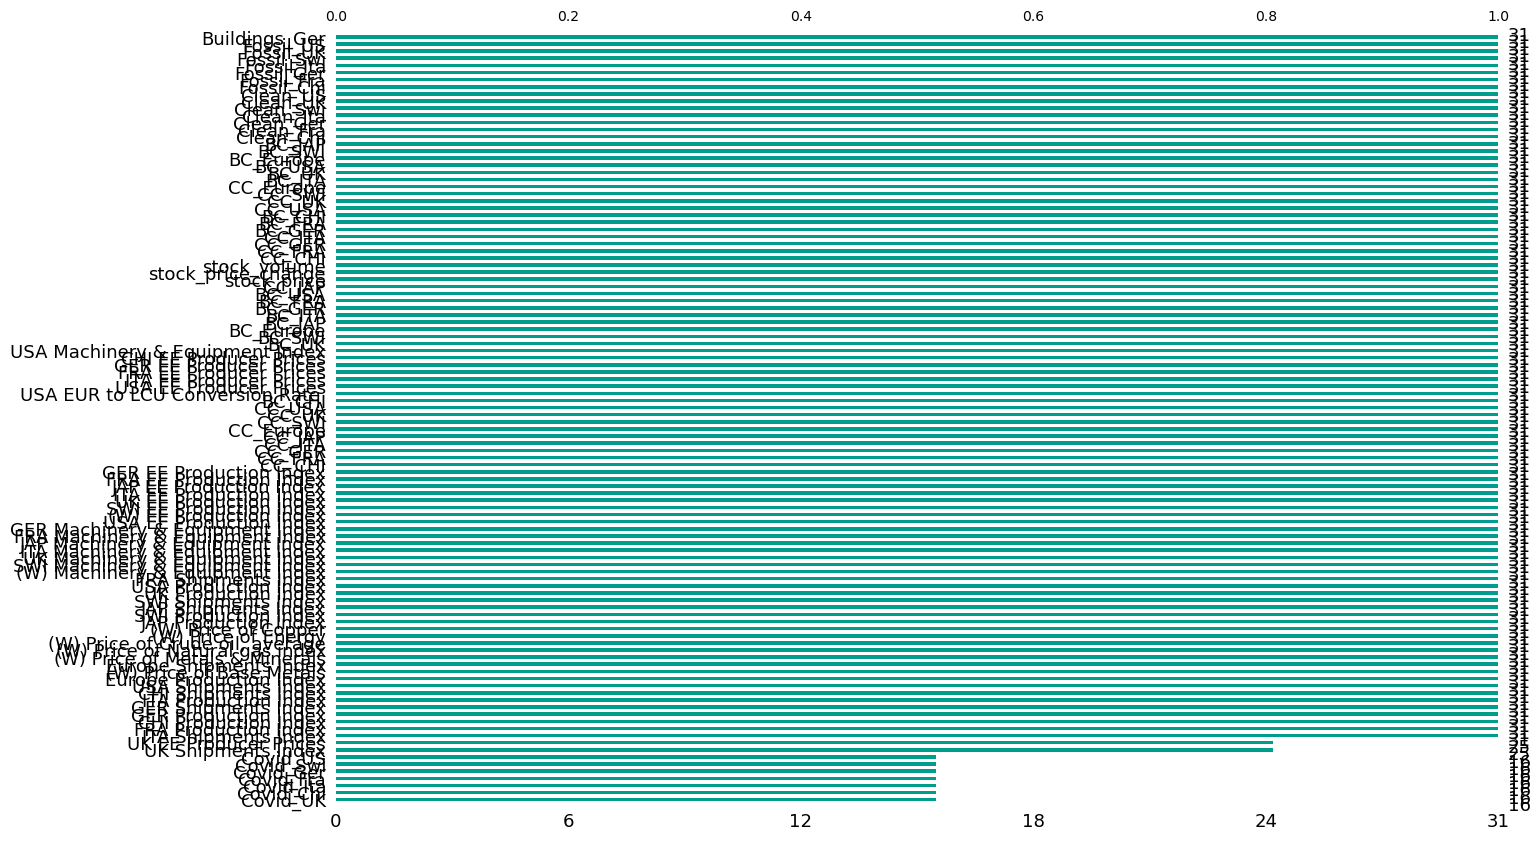

In [30]:
msno.bar(X_train, figsize=(15,10), fontsize=13, 
         color=f.main_color, sort="ascending")

<Axes: >

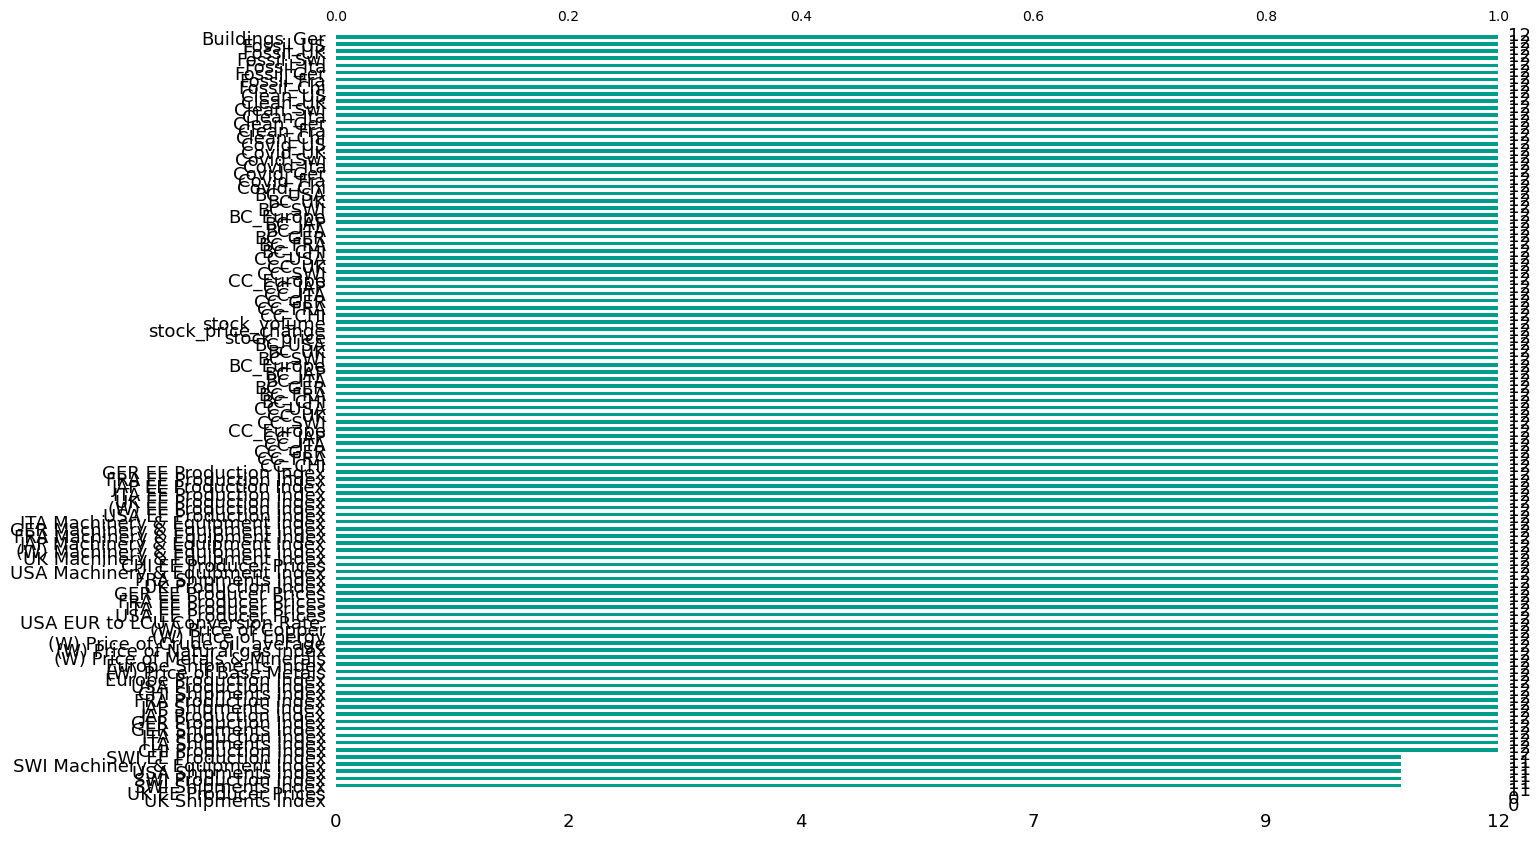

In [31]:
msno.bar(X_val, figsize=(15,10), fontsize=13, 
         color=f.main_color, sort="ascending")

The dataset contains missing values across several indices. The **SWI Production Index**, **SWI Shipments Index**, **USA Shipments Index**, **SWI Machinery & Equipment Index**, and **SWI EE Production Index** each have 1 missing value, accounting for 0.46% of their respective data. The **UK Shipments Index** and **UK EE Producer Prices** have 18 missing values, representing 8.22% of their data. The **FRA EE Producer Prices** has the highest percentage of missing values, with 35 missing entries, making up 15.98% of its data. The **CHI EE Producer Prices** has 23 missing values, contributing to 10.50% of its dataset. Additionally, the **(W) EE Production Index** has 11 missing values, which is 5.02% of its data. 

One option that was considered was obtaining external data, however we were unable to find data to do this.

<div class="alert-danger">
    
adicionar missing values do covid

**Filling Missing values**

<a href="#top">Top &#129033;</a>

Conventional imputation techniques are not applicable for the time-series data since the sequence in which values are received matters.

**Filling Covid Features**

In [27]:
X_train.loc[:, X_train.columns.str.startswith('Covid')] = X_train.loc[:, X_train.columns.str.startswith('Covid')].fillna(0)

**KNN Imputer**

Creating a Pipeline to easily manage Scaling and Imputation

In [28]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('imputer', KNNImputer(n_neighbors=10))
])

Imputation

In [29]:
X_train2 = X_train.copy()
X_val2 = X_val.copy()

# Fit Transform
X_train2_pipelined = pipeline.fit_transform(X_train2)
X_val2_pipelined = pipeline.transform(X_val2)

In [30]:
imputed_data = pipeline.named_steps['scaler'].inverse_transform(X_train2_pipelined)

X_train2 = pd.DataFrame(imputed_data, 
                            columns=X_train2.columns, 
                            index=X_train2.index)

In [31]:
imputed_data = pipeline.named_steps['scaler'].inverse_transform(X_val2_pipelined)

X_val2 = pd.DataFrame(imputed_data, 
                            columns=X_val.columns, 
                            index=X_val.index)

#### Time Imputation

In [37]:
X_train3 = X_train.copy()
X_train3.interpolate(method='time',
                     limit_direction='both',
                     inplace = True)


In [38]:
X_val3 = X_val.copy()
X_val3.interpolate(method='time',
                     limit_direction='both',
                     inplace = True)


**See how imputed values compare with real values**

Allows to visually compare both used methods

In [39]:
train_cols_with_missing = X_train.columns[X_train.isna().any()]
val_cols_with_missing = X_val.columns[X_val.isna().any()]

**KNN Imputation**

In [ ]:
f.plot_imputation(X_train, X_train2, train_cols_with_missing)

In [ ]:
f.plot_imputation(X_val, X_val2, val_cols_with_missing)

**Time Imputation**

In [ ]:
f.plot_imputation(X_train, X_train3, train_cols_with_missing)

In [ ]:
f.plot_imputation(X_val, X_val3, val_cols_with_missing)

**Reassign imputed values**

In [32]:
X_train = X_train2
X_val = X_val2

<br>

## 5.5 Statistical Tests

<a href="#top">Top &#129033;</a>

**y_train**

**Augmented Dickey-Fuller Test for Stationarity**


Used to determine if a time series is stationary or if it has a unit root (non-stationary). Stationarity means that the statistical properties of the time series, such as the mean, variance, and autocorrelation, do not change over time.

- If the p-value is below a chosen significance level (0.05), reject the null hypothesis, and conclude the series is stationary.
- If the p-value is above the significance level, fail to reject the null hypothesis, and conclude the series is non-stationary.

In [ ]:
st.adf_test(y_train, y_train.columns)

In [ ]:
st.adf_test(y_val, y_val.columns)

For the sake of model simplicity, we will not proceed to difference non-stationary features

## 5.6 Feature Engineering

<a href="#top">Top &#129033;</a>

### Sales Data

**Time Related Features**

In [ ]:
# Extract Year and Month from DateTimeIndex
X_train['Year'] = X_train.index.year
X_train['Month'] = X_train.index.month

X_val['Year'] = X_val.index.year
X_val['Month'] = X_val.index.month

In [ ]:
# Create Semester column
X_train['Semester'] = X_train['Month'].apply(f.get_semester)

# Cyclical Encoding for Semester
X_train['sin_Semester'] = np.sin(2 * np.pi * X_train['Semester'] / 2)
X_train['cos_Semester'] = np.cos(2 * np.pi * X_train['Semester'] / 2)

# Create Semester column
X_val['Semester'] = X_val['Month'].apply(f.get_semester)

# Cyclical Encoding for Semester
X_val['sin_Semester'] = np.sin(2 * np.pi * X_val['Semester'] / 2)
X_val['cos_Semester'] = np.cos(2 * np.pi * X_val['Semester'] / 2)

In [ ]:
# Create Quarter column
X_train['Quarter'] = X_train['Month'].apply(f.get_quarter)

# Cyclical Encoding for Quarter
X_train['sin_Quarter'] = np.sin(2 * np.pi * X_train['Quarter'] / 4)
X_train['cos_Quarter'] = np.cos(2 * np.pi * X_train['Quarter'] / 4)

# Create Quarter column
X_val['Quarter'] = X_val['Month'].apply(f.get_quarter)

# Cyclical Encoding for Quarter
X_val['sin_Quarter'] = np.sin(2 * np.pi * X_val['Quarter'] / 4)
X_val['cos_Quarter'] = np.cos(2 * np.pi * X_val['Quarter'] / 4)

In [ ]:
# Create a cyclical feature for Month
X_train['sin_month'] = np.sin(2 * np.pi * X_train['Month'] / 12)
X_train['cos_month'] = np.cos(2 * np.pi * X_train['Month'] / 12)

# Create a cyclical feature for Month
X_val['sin_month'] = np.sin(2 * np.pi * X_val['Month'] / 12)
X_val['cos_month'] = np.cos(2 * np.pi * X_val['Month'] / 12)

In [ ]:
# Apply the function to get both weekend days and total days in the month
X_train[['WeekendDaysCount', 'TotalDaysInMonth']] = X_train.apply(
    lambda row: pd.Series(f.count_weekends_in_month(int(row['Year']), int(row['Month']))), axis=1)

# Calculate the percentage of weekend days in the month
X_train['WeekendDaysPercentage'] = (X_train['WeekendDaysCount'] / X_train['TotalDaysInMonth']) * 100

# Apply the function to get both weekend days and total days in the month
X_val[['WeekendDaysCount', 'TotalDaysInMonth']] = X_val.apply(
    lambda row: pd.Series(f.count_weekends_in_month(int(row['Year']), int(row['Month']))), axis=1)

# Calculate the percentage of weekend days in the month
X_val['WeekendDaysPercentage'] = (X_val['WeekendDaysCount'] / X_val['TotalDaysInMonth']) * 100

In [ ]:
X_train['SundayCount'] = X_train.apply(lambda row: f.count_sundays_in_month(int(row['Year']), int(row['Month'])), axis=1)

X_val['SundayCount'] = X_val.apply(lambda row: f.count_sundays_in_month(int(row['Year']), int(row['Month'])), axis=1)

In [ ]:
X_train['GerHolidayCount'] = X_train.apply(lambda row: f.count_holidays_in_month(X_train, int(row['Year']), int(row['Month'])), axis=1)

X_val['GerHolidayCount'] = X_val.apply(lambda row: f.count_holidays_in_month(X_val, int(row['Year']), int(row['Month'])), axis=1)

<div class="alert-danger">
    
## transformações feitas até aqui
    
- rever oq está feito
- continuar

**Lag Features**

In [ ]:
# Depends on the ACF and PACF
lag_dict = {
    "#1": [1],
    "#3": [1],
    "#4": [1, 6],
    "#5": [1],
    "#6": [1],
    "#8": [1, 3],
    "#9": [1, 12],
    "#11": [1],
    "#12": [1, 3, 12],
    "#13": [1, 3],
    "#14": [1, 6],
    "#16": [1, 3],
    "#20": [1],
    "#36": [1,12]
}

# Lags are created for each product, and rows with missing lag values are removed.
new_monthly_sales = f.create_lag_features(new_monthly_sales, lag_dict)


| Scenario                        | How to Read ACF                                | How to Read PACF                           | What Lags to Use                       |
|----------------------------------|------------------------------------------------|--------------------------------------------|----------------------------------------|
| Short-term dependency            | ACF quickly drops                              | PACF has a strong spike at lag 1           | Use Sales_Lag_1                        |
| Quarterly patterns (every 3 months) | ACF has peaks at lags 3, 6, 9                  | PACF spikes at lag 3                       | Use Sales_Lag_3, Sales_Lag_6           |
| Yearly seasonality (12 months)   | ACF has a peak at lag 12                       | PACF has a spike at lag 12                 | Use Sales_Lag_12                       |
| Gradual decline in ACF           | ACF slowly decreases                           | PACF has multiple spikes                   | Use Sales_Lag_1, Sales_Lag_3, Sales_Lag_12 |


**Rolling Mean**

In [ ]:
# Depends on the ACF and PACF
rolling_dict  = {
    "#4": [6],
    "#8": [3],
    "#9": [12],
    "#12": [3, 12],
    "#13": [3],
    "#14": [6],
    "#16": [3],
    "#36": [12]
}


new_monthly_sales = f.create_rolling_mean_features(new_monthly_sales, rolling_dict)

<div class="alert-warning">
    
missing values a aparecer

In [ ]:
#pd.reset_option('display.max_rows', None)
new_monthly_sales.isna().sum()

## 5.7 Outliers

<a href="#top">Top &#129033;</a>

### 5.5.1 Outlier Identification

**ADF, Autocorrelation and Partial Autocorrelation**

Useful to visually identify outliers

In [ ]:
st.outliers_stationarity(y_train)

| Column | Outliers |
| ------ | -------- |
| #1 | 2018-11 |
| #3 | 2021-01 |
| #4 | - |
| #5 | 2021-01 |
| #6 | - |
| #8 | - |
| #9 | 2020-10, 2020-11 |
| #11 | - |
| #12 | - |
| #13 | - |
| #14 | 2019-06 |
| #16 | 2018-12, 2019-3 |
| #20 | - |
| #36 | 2020-06, 2021-04 |




**Boxplots**

In [ ]:
f.plot_distribution_and_boxplot(y_train, 
                              y_train.columns[0], 
                              n_bins=30,
                              out_left = 20000000)

In [ ]:
f.plot_distribution_and_boxplot(y_train, 
                               y_train.columns[1], 
                               n_bins=30,
                               out_left = 6000000)

In [ ]:
f.plot_distribution_and_boxplot(y_train, 
                              y_train.columns[2], 
                              n_bins=30,
                              out_right = 750000)

In [ ]:
f.plot_distribution_and_boxplot(y_train, 
                              y_train.columns[3], 
                              n_bins=30)

In [ ]:
f.plot_distribution_and_boxplot(y_train, 
                              y_train.columns[4], 
                              n_bins=30)

In [ ]:
f.plot_distribution_and_boxplot(y_train, 
                              y_train.columns[5], 
                              n_bins=30)

In [ ]:
f.plot_distribution_and_boxplot(y_train, 
                              y_train.columns[6], 
                              n_bins=30,
                              out_right = 21000)

In [ ]:
f.plot_distribution_and_boxplot(y_train, 
                              y_train.columns[7], 
                              n_bins=30)

In [ ]:
f.plot_distribution_and_boxplot(y_train, 
                              y_train.columns[8], 
                              n_bins=30)

In [ ]:
f.plot_distribution_and_boxplot(y_train, 
                              y_train.columns[9], 
                              n_bins=30,
                              out_right = 60000)

In [ ]:
f.plot_distribution_and_boxplot(y_train, 
                              y_train.columns[10], 
                              n_bins=30,
                              out_right = 40000)

In [ ]:
f.plot_distribution_and_boxplot(y_train, 
                              y_train.columns[11], 
                              n_bins=30,
                              out_right = 600000)

In [ ]:
f.plot_distribution_and_boxplot(y_train, 
                              y_train.columns[12], 
                              n_bins=30,
                              out_right = 7000)

In [ ]:
f.plot_distribution_and_boxplot(y_train, 
                              y_train.columns[13], 
                              n_bins=30,
                              out_right = 100000)

### 5.5.2 Outlier Treatment

<a href="#top">Top &#129033;</a>

In [ ]:
clean_y_train = y_train.copy()

`#1`

In [ ]:
clean_y_train[clean_y_train['#1'] < 20000000]

In [ ]:
median_value = clean_y_train['#1'].median()
clean_y_train.loc[clean_y_train['#1'] < 20000000, '#1'] = median_value

`#3`

In [ ]:
clean_y_train[(clean_y_train['#3'] < 6000000)]

In [ ]:
median_value = clean_y_train['#3'].median()
clean_y_train.loc[clean_y_train['#3'] < 6000000, '#3'] = median_value

`#4`

In [ ]:
clean_y_train[(clean_y_train['#4'] > 750000)]

In [ ]:
median_value = clean_y_train['#4'].median()
clean_y_train.loc[clean_y_train['#4'] > 750000, '#4'] = median_value

`#9`

In [ ]:
clean_y_train[(clean_y_train['#9'] > 21000)]

In [ ]:
median_value = clean_y_train['#9'].median()
clean_y_train.loc[clean_y_train['#9'] > 21000, '#9'] = median_value

`#13`

In [ ]:
clean_y_train[(clean_y_train['#13'] > 60000)]

In [ ]:
median_value = clean_y_train['#13'].median()
clean_y_train.loc[clean_y_train['#13'] > 60000, '#13'] = median_value

`#14`

In [ ]:
clean_y_train[(clean_y_train['#14'] > 40000)]

In [ ]:
median_value = clean_y_train['#14'].median()
clean_y_train.loc[clean_y_train['#14'] > 40000, '#14'] = median_value

`#16`

In [ ]:
clean_y_train[(clean_y_train['#16'] > 600000)]

In [ ]:
median_value = clean_y_train['#16'].median()
clean_y_train.loc[clean_y_train['#16'] > 600000, '#16'] = median_value

`#20`

In [ ]:
clean_y_train[(clean_y_train['#20'] > 7000)]

In [ ]:
median_value = clean_y_train['#20'].median()
clean_y_train.loc[clean_y_train['#20'] > 7000, '#20'] = median_value

`#36`

In [ ]:
clean_y_train[(clean_y_train['#36'] > 100000)]

In [ ]:
median_value = clean_y_train['#36'].median()
clean_y_train.loc[clean_y_train['#36'] > 100000, '#36'] = median_value

**Check the Success**

In [ ]:
st.outliers_stationarity(clean_y_train)

In [ ]:
cols = clean_y_train.columns

for col in cols:
    f.plot_distribution_and_boxplot(clean_y_train, col, n_bins=30)

Save temporary dataframe to the original one

In [ ]:
y_train = clean_y_train
y_train.head(2)

# 6. Final Datasets

<a href="#top">Top &#129033;</a>

In [ ]:
# Initialize an empty list to store the variable names
y_train_names = []
y_val_names = []


for y_col in y_train.columns:
    # Extract only the numbers from the column name
    y_col_number = ''.join(filter(str.isdigit, y_col))
    
    # Create a new y_train column and assign it to a new variable
    y_train_col = y_train[y_col]
    
    # Generate the variable name using the numeric part of the column name
    y_train_var_name = f"y_train_{y_col_number}"
    
    # Assign the y_train column to the dynamically created variable name
    globals()[y_train_var_name] = y_train_col
    
    # Append the variable name to the list
    y_train_names.append(y_train_var_name)


for y_col in y_val.columns:
    # Extract only the numbers from the column name
    y_col_number = ''.join(filter(str.isdigit, y_col))
    
    # Create a new y_val column and assign it to a new variable
    y_val_col = y_val[y_col]
    
    # Generate the variable name using the numeric part of the column name
    y_val_var_name = f"y_val_{y_col_number}"
    
    # Assign the y_val column to the dynamically created variable name
    globals()[y_val_var_name] = y_val_col
    
    # Append the variable name to the list
    y_val_names.append(y_val_var_name)

print("y_train variable names:", y_train_names)
print('')
print("y_val variable names:", y_val_names)


In [ ]:
y_train_1.head(2)

In [ ]:
y_val_1.head(2)

**Export Data**

In [ ]:
train_folder = './data/y_train_data'
val_folder = './data/y_val_data'

# Create the directories if they do not exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)

In [ ]:
# Export y_train variables to CSV files in the train folder
for var_name in y_train_names:
    # Access the variable using globals()
    y_train_data = globals()[var_name]
    
    # Export the variable to a CSV file inside the train folder
    y_train_data.to_csv(f"{train_folder}/{var_name}.csv", index=False)

# Export y_val variables to CSV files in the val folder
for var_name in y_val_names:
    # Access the variable using globals()
    y_val_data = globals()[var_name]
    
    # Export the variable to a CSV file inside the val folder
    y_val_data.to_csv(f"{val_folder}/{var_name}.csv", index=False)

In [ ]:
X_train.to_csv('./data/X_train_data/X_train.csv')
X_val.to_csv('./data/X_val_data/X_val.csv')